# Bulk short read RNA-seq exploratory analysis with python

We have data from 2 patient-derived muscle cell lines, Control and FSHD2, that were differentiated in culture over 5 days as described in [this paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1008754). Bulk short-read RNA-seq was performed using polyA primers and Illumina sequencing. There are 48 total samples from the 2 conditions across 6 timepoints (0-5 days), 2 biological replicates, and 2 technical replicates each, but I just had you map 8 samples: Control and FSHD2 at 3 and 5 days, 1 biological replicate and 2 technical replicates each. 

To quantify gene expression, reads were mapped to the human genome using [kallisto](https://pachterlab.github.io/kallisto/about), and the resulting counts were saved as a tsv file for each sample.

This notebook assumes you have run `kallisto_quant.sh` (and therefore have a `kallisto_output` folder one directory above this one). 

# Import data into python

Concatenate all samples together into 1 gene expression matrix of RNA quantifications normalized by TPM (transcripts per million). TPM accounts for the total number of reads that the sample got when it was sequenced, and the length of the transcript. Transcript lengths (# bases) vary a lot! Compare the Titin transcript at > 100,000 base pairs vs. the average length of a human transcript ~2,000 base pairs.

In [1]:
# Load some libraries 
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.decomposition import PCA

sns.set_context("paper", font_scale=2)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Read in metadata file; only really care about certain columns for plotting purposes
metadata = pd.read_csv("/data/class/cosmos2023/PUBLIC/ta-github/data/fshd_metadata.csv", 
                       usecols=['Run', 'Sample', 'Individual', 'fshd_status', 'day_of_differentiation'])

In [3]:
# Directory containing the output folders 
output_dir = '../kallisto_output'

# If you had trouble running kallisto_quant.sh, use the output in the results folder from ta-github:
#output_dir = 'results/kallisto_output'

# List to store individual dataframes
dfs = []

In [4]:
# Loop through each folder in the output directory
for folder in os.listdir(output_dir):
    folder_path = os.path.join(output_dir, folder)
    file_path = os.path.join(folder_path, 'gene_abundance.tsv')

    # Read gene_abundance.tsv as a dataframe
    df = pd.read_csv(file_path, sep ='\t')
    tpm_col = df['tpm']  # Extract tpm column
    dfs.append(tpm_col) # Add gene expression measurements from each sample to a growing list

In [5]:
# Create a dataframe from the list of measurements from all the samples
merged_df = pd.concat(dfs, axis=1)
merged_df.columns = os.listdir(output_dir)  # Assign sample names as column names


In [6]:
# Create a dictionary mapping Run to Sample from the metadata
column_mapping = dict(zip(metadata['Run'], metadata['Sample']))

# Rename the columns using the mapping
merged_df.rename(columns=column_mapping, inplace=True)

# Reorder columns (not necessary, just makes it nicer to look at)
column_order = ['Control-1 Day 3 Rep 1', 'Control-1 Day 3 Rep 2', 
                'Control-1 Day 5 Rep 1', 'Control-1 Day 5 Rep 2', 
                'FSHD2-1 Day 3 Rep 1', 'FSHD2-1 Day 3 Rep 2', 
                'FSHD2-1 Day 5 Rep 1', 'FSHD2-1 Day 5 Rep 2']
merged_df = merged_df.reindex(columns=column_order)

# Merge gene info with the merged dataframe
# axis = 1 means concatenate by column, not row (row would be axis = 0)
final_df = pd.concat([df[['gene_id','gene_name']], merged_df], axis=1)

# Write the merged dataframe to a new file
final_df.to_csv('data/tpm_matrix.tsv', sep='\t', index=False)


# PCA (principal component analysis) 
[5-minute explanation of PCA on Youtube](https://www.youtube.com/watch?v=HMOI_lkzW08&t=28s)

In [7]:
input_df = merged_df.transpose() # transpose the matrix without gene names / ids
data = input_df.values # just get the numbers
pca = PCA(merged_df.shape[1]) # compute the same # of PCs as samples
pca.fit(data)

PCA(n_components=8)

   prop_variance  pct_variance  PC
0   6.148922e-01  6.148922e+01   1
1   2.019525e-01  2.019525e+01   2
2   9.152513e-02  9.152513e+00   3
3   4.755336e-02  4.755336e+00   4
4   3.129849e-02  3.129849e+00   5
5   6.967970e-03  6.967970e-01   6
6   5.810383e-03  5.810383e-01   7
7   7.328994e-31  7.328994e-29   8


/opt/apps/python/3.8.0/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


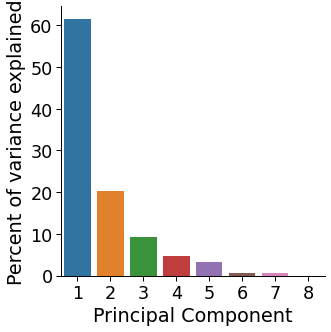

In [8]:
# Make df to plot the percent variance explained
pca_df = pd.DataFrame(data=pca.explained_variance_ratio_,
                      columns=['prop_variance'])

# compute percent variance from proportion variance
pca_df['pct_variance'] = pca_df.prop_variance*100
pca_df['PC'] = list(range(1, merged_df.shape[1]+1))
print(pca_df)

# Use Seaborn library to make categorical bar plot
ax = sns.catplot(data=pca_df, x='PC', y='pct_variance', kind='bar')

# Add nice x and y axis labels
ax.set(ylabel='Percent of variance explained', xlabel='Principal Component')

In [9]:
# first calculate the PCA representation of the data
pca_data = pca.transform(data) 
cols = ['PC{} ({:.1f}%)'.format(pc, var) for pc, var in zip(pca_df.PC, pca_df.pct_variance)]
print(cols)
pca_df = pd.DataFrame(data=pca_data, columns=cols)
pca_df.set_index(input_df.index, inplace=True)

# Perform a merge based on matching indices
pca_df = pca_df.merge(metadata, left_index=True, right_on='Sample')

['PC1 (61.5%)', 'PC2 (20.2%)', 'PC3 (9.2%)', 'PC4 (4.8%)', 'PC5 (3.1%)', 'PC6 (0.7%)', 'PC7 (0.6%)', 'PC8 (0.0%)']


In [10]:
pca_df

,PC1 (61.5%),PC2 (20.2%),PC3 (9.2%),PC4 (4.8%),PC5 (3.1%),PC6 (0.7%),PC7 (0.6%),PC8 (0.0%),Run,day_of_differentiation,fshd_status,Sample,Individual
6,6947.120117,2914.772955,2933.697604,-3010.679085,-342.832219,1143.102617,-408.828212,3.045386e-11,SRR10870729,Day 3,Control,Control-1 Day 3 Rep 1,Control-1
7,13638.782562,378.496298,-3670.111223,-843.754259,-101.133940,-978.420201,358.912401,1.818989e-11,SRR10870730,Day 3,Control,Control-1 Day 3 Rep 2,Control-1
10,-4962.785673,5964.685235,-528.201277,1724.313824,-1828.731670,397.311846,1114.963929,1.244871e-11,SRR10870733,Day 5,Control,Control-1 Day 5 Rep 1,Control-1
11,-3909.663918,6137.266396,-68.748568,1380.285033,2270.645444,-540.138481,-985.548773,-9.379164e-12,SRR10870734,Day 5,Control,Control-1 Day 5 Rep 2,Control-1
42,5533.850902,-5287.711189,-236.023827,3776.058975,-200.657217,836.914942,-449.286046,8.029133e-12,SRR10870765,Day 3,FSHD2,FSHD2-1 Day 3 Rep 1,FSHD2-1
43,-1034.569559,-3332.351452,5821.212920,148.701124,140.426135,-1035.637449,501.372003,-6.679102e-13,SRR10870766,Day 3,FSHD2,FSHD2-1 Day 3 Rep 2,FSHD2-1
46,-9124.282688,-2933.971799,-1952.360210,-1537.243530,-2583.750250,-399.892029,-833.793781,-2.822276e-11,SRR10870769,Day 5,FSHD2,FSHD2-1 Day 5 Rep 1,FSHD2-1
47,-7088.451743,-3841.186444,-2299.465420,-1637.682081,2646.033715,576.758755,702.208479,-1.262634e-11,SRR10870770,Day 5,FSHD2,FSHD2-1 Day 5 Rep 2,FSHD2-1


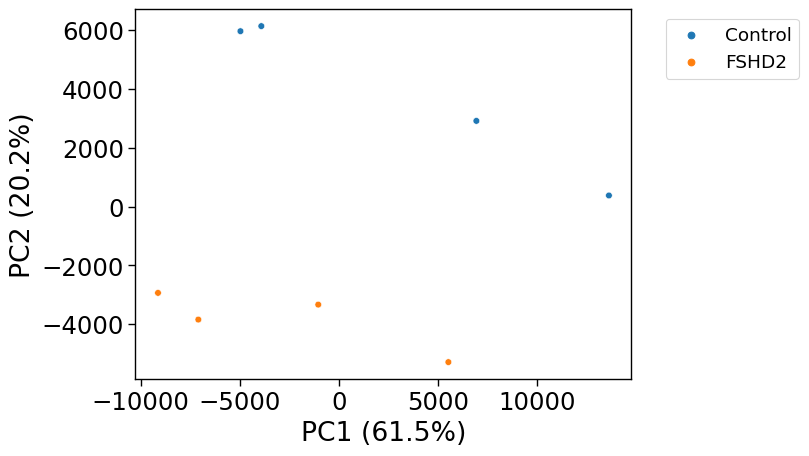

In [11]:
ax = sns.scatterplot(data=pca_df, x=cols[0], y=cols[1], hue='fshd_status')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')

## make it pretty!

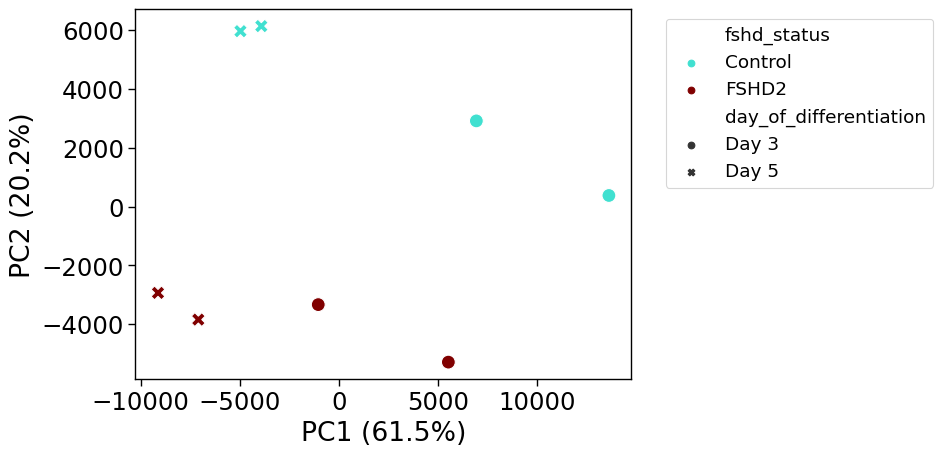

In [12]:
# Make a mini dictionary to assign color to fshd status
c_dict = {'FSHD2': 'maroon', 
          'Control': 'turquoise' }

ax = sns.scatterplot(data=pca_df, x=cols[0], y=cols[1], 
                     s=100, # size of point
                     hue='fshd_status', palette=c_dict, style='day_of_differentiation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='x-small')


# Heatmap

In [13]:
# Set index to be gene names so heatmap is easier to read
hmap_df = final_df.set_index('gene_name')
hmap_df = hmap_df.drop(columns='gene_id') # don't need gene IDs right now

# order based on expression so we can get some highly-expressed guys
# (but usually for these you'll want to curate the set of genes in a more intelligent way)
hmap_df['total'] = hmap_df.sum(axis=1)
hmap_df.sort_values(by='total', ascending=False, inplace=True)
hmap_df.drop('total', axis=1, inplace=True)

# log2 transform and add pseudocount -- common way to transform RNA-seq data for visualization
hmap_df = np.log2(hmap_df + 1) 

# show top 15 genes
hmap_top15 = hmap_df[:15] 

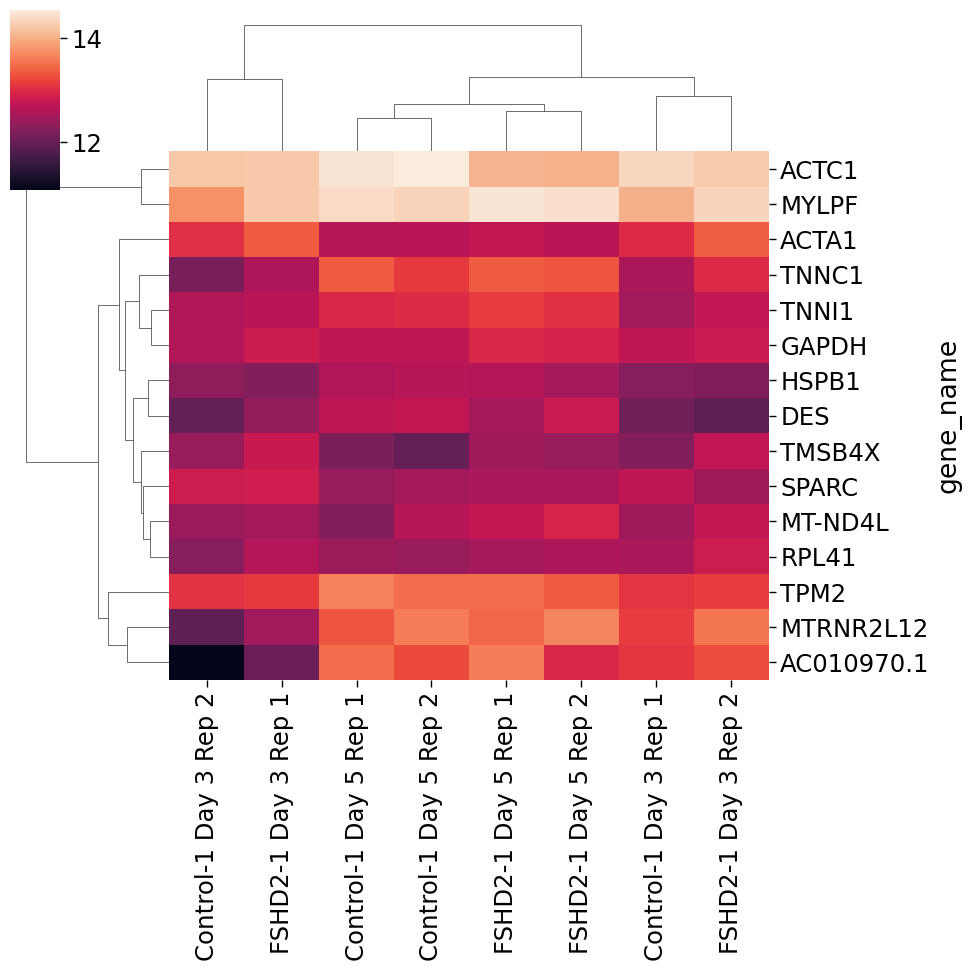

In [14]:
# Use clustermap function in seaborn to make heatmap
ax = sns.clustermap(data=hmap_top15)

# Try to recreate part of figure 1c from the paper

In [15]:
genes = pd.read_csv("/data/class/cosmos2023/PUBLIC/ta-github/data/Fig1C_genes.csv")


In [16]:
# subset df for the genes that were in the figure
hmap_paper = hmap_df[hmap_df.index.isin(genes['gene_name'])]

## make it pretty!

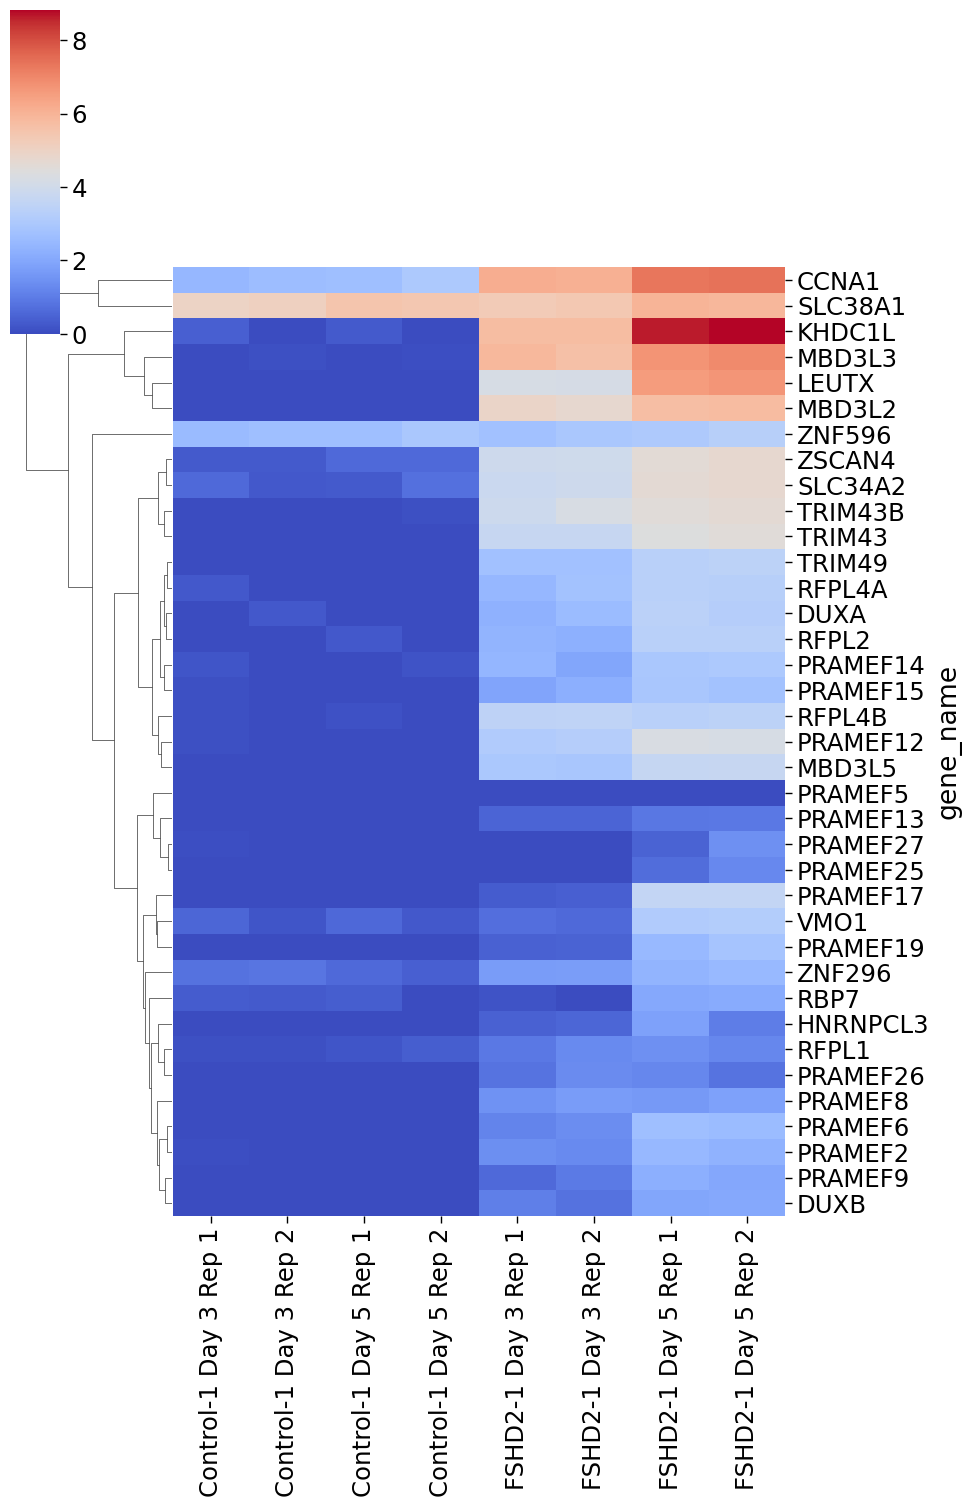

In [20]:
# Set the desired width and height in inches
width = 10
height = 18

# Turn off column clustering, change color map, and adjust the yticklabels to label every row
ax = sns.clustermap(data=hmap_paper, col_cluster=False, cmap="coolwarm", yticklabels=True)

# Set the figsize parameter of the clustermap plot
ax.figure.set_size_inches(width, height)